In [1]:
import numpy as np
import torch
import sklearn
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
from keras.datasets import cifar10

In [56]:
class Cifar10Classifier(torch.nn.Module):

    def __init__(self):
        super(Cifar10Classifier, self).__init__()

        self.features = torch.nn.Sequential(                                                        # inp: B 3 32 32
            torch.nn.BatchNorm2d(num_features=3),
            torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1),    # B 96 32 32
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),   # B 96 32 32
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # B 96 16 16
            torch.nn.Dropout2d(0.2),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, stride=1, padding=1),  # B 192 16 16
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1), # B 192 16 16
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # B 192 8 8
            torch.nn.Dropout2d(0.2),
            torch.nn.BatchNorm2d(num_features=192),
            torch.nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1), # B 384 8 8
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1), # B 384 8 8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # B 384 4 4
            torch.nn.Dropout2d(0.2)
        )

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4 * 4 * 384, 128),                                                      # B 4 * 4 * 384
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)                                                                # B 10
        )

        self.log_prob_cal = torch.nn.LogSoftmax(dim=-1)

        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr=0.001
        )

        self.batch_x_placeholder = torch.zeros(size=[1, 3, 32, 32], dtype=torch.float32, device=torch.device('cuda:0'))
        self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))
    
    def forward(self, b_x, b_y=None):
        conv_features = self.features(b_x)
        class_scores = self.decider(conv_features.flatten(1))
        log_probs = self.log_prob_cal(class_scores)
        loss = -1 * torch.mean(log_probs[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(log_probs, dim=-1)
        return decision, loss
    
    def train_epoch(self, X_train, y_train, batch_size):
        self.train()

        iters_per_epoch = int(np.ceil(1.0 * len(X_train) / batch_size))

        # shuffling
        indices = np.arange(len(X_train))

        epoch_loss = 0
        tps = 0

        # iterate over training set
        for iter in range(iters_per_epoch):
            batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

            # reshape placeholder
            if len(batch_indices) != len(self.batch_x_placeholder):
                self.batch_x_placeholder.resize_([len(batch_indices), 3, 32, 32])
                self.batch_y_placeholder.resize_([len(batch_indices)])

            self.batch_x_placeholder.copy_(torch.Tensor(X_train[batch_indices, :, :, :]))
            self.batch_y_placeholder.copy_(torch.Tensor(y_train[batch_indices].astype(int)))

            b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()

            epoch_loss += float(b_loss) / iters_per_epoch
            tps += np.sum(y_train[batch_indices].astype(int) == b_decision)

            b_loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            
        epoch_train_accuracy = tps * 100.0 / len(X_train)

        return epoch_loss, epoch_train_accuracy
    
    def evaluate(self, X, y, batch_size):
        with torch.no_grad():
            self.eval()

            iters_per_epoch = int(np.ceil(1.0 * len(X) / batch_size))

            indices = np.arange(len(X))
            np.random.shuffle(indices)

            loss = 0
            tps = 0

            for iter in range(iters_per_epoch):
                batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

                # reshape placeholder
                if len(batch_indices) != len(self.batch_x_placeholder):
                    self.batch_x_placeholder.resize_([len(batch_indices), 3, 32, 32])
                    self.batch_y_placeholder.resize_([len(batch_indices)])
                    
                self.batch_x_placeholder.copy_(torch.Tensor(X[batch_indices]))
                self.batch_y_placeholder.copy_(torch.Tensor(y[batch_indices].astype(int)))

                b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)
                b_decision = b_decision.cpu().numpy()

                loss += float(b_loss) / iters_per_epoch
                tps += np.sum(y[batch_indices].astype(int) == b_decision)

            accuracy = tps * 100.0 / len(X)

            return loss, accuracy

    def fit(self, X_train, y_train, epochs, batch_size):
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

        train_loss = np.zeros((epochs,))
        val_loss = np.zeros((epochs,))
        train_acc = np.zeros((epochs,))
        val_acc = np.zeros((epochs,))

        val_iters_per_epoch = int(np.ceil(1.0 * len(X_val) / batch_size))

        for e in range(epochs):
            t_start = time()

            # train over dataset
            epoch_train_loss, epoch_train_accuracy = self.train_epoch(X_train, y_train, batch_size)
            train_loss[e] = epoch_train_loss
            train_acc[e] = epoch_train_accuracy

            # validating over validation set
            epoch_val_loss, epoch_val_accuracy = self.evaluate(X_val, y_val, batch_size)
            val_loss[e] = epoch_val_loss
            val_acc[e] = epoch_val_accuracy

            #saving model
            torch.save({
                    'epoch': e,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'model_state_dict': self.state_dict(),
                    'epoch_train_loss': epoch_train_loss,
                    'epoch_train_accuracy': epoch_train_accuracy,
                    'epoch_val_loss': epoch_val_loss,
                    'epoch_val_accuracy': epoch_val_accuracy
                }, f'CIFAR10/epoch_{e}_state.pt')

            print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_train_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {epoch_val_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')
        
        return train_loss, val_loss, train_acc, val_acc

In [31]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [32]:
X_train = np.transpose(X_train, axes=(0, 3, 1, 2))
X_train.shape

(50000, 3, 32, 32)

In [33]:
X_test = np.transpose(X_test, axes=(0, 3, 1, 2))
X_test.shape

(10000, 3, 32, 32)

In [34]:
y_train = y_train.reshape((50000,))
y_train.shape

(50000,)

In [35]:
y_test = y_test.reshape((10000,))
y_test.shape

(10000,)

In [60]:
batch_size = 32
epochs = 40

In [61]:
model = Cifar10Classifier()
model = model.cuda()

In [62]:
train_loss, val_loss, train_acc, val_acc = model.fit(X_train, y_train, epochs, batch_size)

Epoch 0 finished in 50.00s. loss: 1.5988 - acc: 41.19 - val loss: 1.2077 - val acc: 56.50
Epoch 1 finished in 49.87s. loss: 1.2166 - acc: 56.41 - val loss: 1.0087 - val acc: 64.40
Epoch 2 finished in 49.88s. loss: 1.0276 - acc: 63.85 - val loss: 0.8703 - val acc: 69.83
Epoch 3 finished in 49.91s. loss: 0.9042 - acc: 68.50 - val loss: 0.7553 - val acc: 73.73
Epoch 4 finished in 49.92s. loss: 0.8105 - acc: 72.13 - val loss: 0.7304 - val acc: 74.56
Epoch 5 finished in 49.95s. loss: 0.7459 - acc: 74.25 - val loss: 0.6862 - val acc: 76.39
Epoch 6 finished in 49.93s. loss: 0.6932 - acc: 76.12 - val loss: 0.6446 - val acc: 77.80
Epoch 7 finished in 49.89s. loss: 0.6413 - acc: 77.86 - val loss: 0.6240 - val acc: 78.99
Epoch 8 finished in 49.93s. loss: 0.6068 - acc: 79.02 - val loss: 0.6184 - val acc: 79.06
Epoch 9 finished in 49.86s. loss: 0.5649 - acc: 80.61 - val loss: 0.5712 - val acc: 81.06
Epoch 10 finished in 49.88s. loss: 0.5394 - acc: 81.58 - val loss: 0.5754 - val acc: 81.05
Epoch 11 

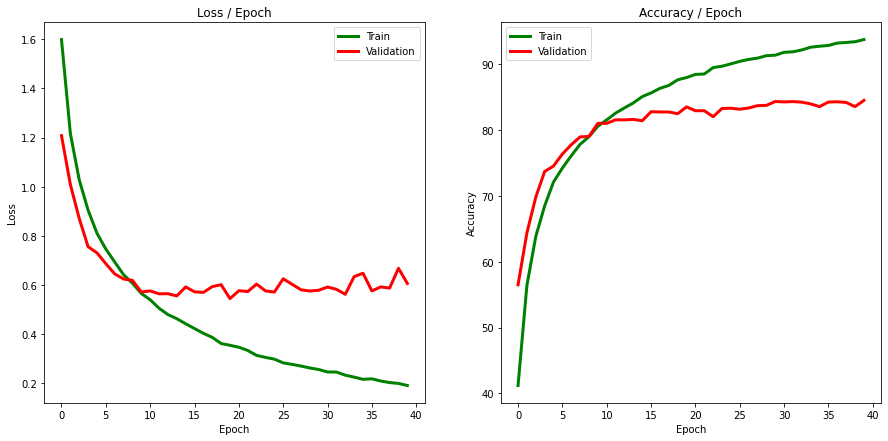

In [63]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()

In [64]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size)
print(f'Test loss: {test_loss:.4f} - Accuracy: {test_accuracy:.2f}')

Test loss: 0.6242 - Accuracy: 84.84
